In [1]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
import numpy as np

In [2]:
init_data = load_breast_cancer()
(X, y) = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(data=X, columns=init_data['feature_names'])
y = pd.DataFrame(data=y, columns=['label'])
y = np.where(y==0, -1, 1) #label改成 -1, 1
X.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# Extract 2 features using PCA.
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

sc = StandardScaler()
Z = sc.fit_transform(X)
R = np.dot(Z.T, Z) / X.shape[0]

eigen_vals, eigen_vecs = np.linalg.eigh(R)
print('Eigenvalues：\n%s\n' % eigen_vals)

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(reverse=True)

W_2D = np.hstack((eigen_pairs[0][1][:, np.newaxis],
                  eigen_pairs[1][1][:, np.newaxis]))

X_pca = np.dot(Z, W_2D)

Eigenvalues：
[  1.33044823e-04   7.48803097e-04   1.58933787e-03   6.90046388e-03
   8.17763986e-03   1.54812714e-02   1.80550070e-02   2.43408378e-02
   2.74394025e-02   2.99728939e-02   3.11594025e-02   4.94775918e-02
   5.26187835e-02   5.93990378e-02   7.98628010e-02   9.41349650e-02
   1.57009724e-01   2.41357496e-01   2.61161370e-01   2.93915696e-01
   3.50693457e-01   4.16894812e-01   4.76617140e-01   6.75220114e-01
   1.20735661e+00   1.64873055e+00   1.98064047e+00   2.81794898e+00
   5.69135461e+00   1.32816077e+01]



In [4]:
# Split training and testing data (test_size = 30% of the whole dataset)
#y_array = y.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=0)


In [5]:
# Handcrafted Adaline classifier.
from numpy.random import seed

class AdalineSGD():
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.w_init = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
            
    def fit(self, X, y):
        self._initialize_w(X.shape[1])
        self.epoch_cost = []
        
        for i in range(self.n_iter):
            cost = []
            if self.shuffle:
                X, y = self._shuffle_data(X, y) # shuffle the data
            for xi, target in zip(X, y):
                cost.append(self._update_w(xi, target))
            avg_cost = sum(cost)/len(y)
            self.epoch_cost.append(avg_cost)
            #print(epoch_cost)
        return self
    
    def partial_fit(self, X, y):
        if not self.w_init:
            self._initialize_w(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_w(xi, target)
        else:
            self.update_w(X, y)
        return self
    def predict(self, X):
        output = np.dot(X, self.w[1:]) + self.w[0]
        return np.where(output >= 0.0, 1, -1)
    def _initialize_w(self, w_size):
        self.w = np.random.normal(loc=0.0, scale=0.01, size=1+w_size)
        self.w_init = True 
    def _shuffle_data(self, X, y):
        random_indices = np.random.permutation(len(y))
        return X[random_indices], y[random_indices]
    def _update_w(self, xi, target):
        # rule：w_(t+1) = w_t + eta * x_i‧sum( (y_i - w_t‧x_i) )
        output = np.dot(xi, self.w[1:]) + self.w[0]
        error = target - output
        self.w[1:] += self.eta * xi * error
        self.w[0] += self.eta * error # 對w0來說，x0是1，所以dot後還是 error
        cost = 0.5 * error**2
        return cost


In [6]:
from sklearn.metrics import accuracy_score

max_accuracy = 0.0
best_eta = 0.0
for i in np.arange(0.001, 0.1001, 0.0001):
    adaSGD = AdalineSGD(eta=i, n_iter=30, shuffle=True, random_state=1)
    adaSGD.fit(X_train, y_train)
    y_pred = adaSGD.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy_score(y_test, y_pred) > max_accuracy:
        max_accuracy = accuracy_score(y_test, y_pred)
        best_eta = i
print('Max accuracy：%f' % max_accuracy)
print('Best Eta:%f' % best_eta)

Max accuracy：0.941520
Best Eta:0.003200


Accuracy: 0.94


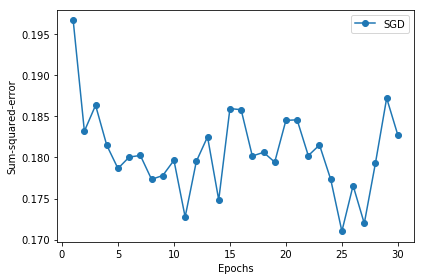

In [7]:
# cost values
import matplotlib.pyplot as plt
adaSGD = AdalineSGD(eta=best_eta, n_iter=30, shuffle=True, random_state=1)
adaSGD.fit(X_train, y_train)

y_pred = adaSGD.predict(X_test)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# visulize
plt.plot(range(1, len(adaSGD.epoch_cost) + 1), adaSGD.epoch_cost, 
         marker='o', label='SGD')

plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('Lab04-1_106062541.png', dpi=300)
plt.show()